##Inicialização


Foram usados como base de análise dois datasets: o primeiro contendo os dados das seções judiciárias do Tribunal Regional Federal da 5ª Região, e o segundo contendo os dados apenas dos processos que foram encaminhados para Segundo Grau. 

Toda essa primeira seção é dedicada à parte inicial da análise, ou seja, é voltada para as etapas de conexão, importação das bibliotecas necessárias, leitura e limpeza dos dados e - por fim e nesse caso - junção dos dois datasets em questão. 


###Conexão

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!unzip '/content/drive/My Drive/Dados IC/IC.zip'

###Importação


In [ ]:
!pip install wordcloud
!pip install folium==0.8.2
!pip install squarify

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import squarify 
import folium
import requests
import json
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import concurrent.futures
import re
import multiprocessing
import networkx as nx
import itertools
import concurrent.futures
import time
import seaborn as sns


from bs4 import BeautifulSoup
from lxml import html
from folium import plugins
from folium import Circle
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.pyplot import cm

###Leitura

In [ ]:
#Conexão e leitura do arquivo PJe-JF.sqlite3
#Seções Judiciárias

connection = sqlite3.connect('/content/PJe-JF.sqlite3')

df_al = pd.read_sql_query("SELECT * from AL", connection)
df_ce = pd.read_sql_query("SELECT * from CE", connection)
df_pb = pd.read_sql_query("SELECT * from PB", connection)
df_pe = pd.read_sql_query("SELECT * from PE", connection)
df_rn = pd.read_sql_query("SELECT * from RN", connection)
df_se = pd.read_sql_query("SELECT * from SE", connection)

data_jf = [df_al, df_ce, df_pb, df_pe, df_rn, df_se]
df_jf = pd.concat(data_jf)

In [ ]:
#Conexão e leitura do arquivo PJe-TRF.sqlite3
#Segundo Grau

connection = sqlite3.connect('/content/PJe-TRF.sqlite3')

df_proc = pd.read_sql_query("SELECT * from processos", connection)
df_dec = pd.read_sql_query("SELECT * from decisoes", connection)
df_mov = pd.read_sql_query("SELECT * from movimentacoes", connection)

connection.close()

###Limpeza


In [ ]:
#Limpeza dos dados nulos 
for d in data_jf:
  d.drop(d.index[d['num_processo'] == '0'], inplace = True)
df_jf.drop(df_jf.index[df_jf['num_processo'] == '0'], inplace = True)

###Junção dos datasets

Os dois datasets foram unidos através de uma chave única: o número de processo. Após a junção foi observado a existência de linhas duplicadas, de modo que essas que foram removidas, mantendo apenas a primeira aparição de cada uma delas.


In [ ]:
#Unindo as tabelas através do numero de processo
data_merged = pd.merge(left=df_jf,right=df_proc,  left_on='num_processo', right_on='num_processo')

#Removendo as entradas duplicadas
new_data = data_merged[data_merged.duplicated(keep='first') == False]

##Assuntos mais frequentes em processos que foram para Segundo Grau

###1ª versão - sem agrupamento de palavras


A primeira versão do wordcloud (nuvem de palavras) contava apenas com os assuntos de cada processo separados em termos. Cada assunto apresenta cerca de 4  termos diferentes, cada um representando - de certa forma - um grau de agrupamento do título dos processos. 

Nessa versão, foi separada apenas a área geral (o tipo de direito ao qual o processo se refere, sempre o primeiro termo do assunto) e os demais termos foram salvos em uma lista. No entanto, as palavras de cada termo não estavam ligadas entre si, de forma que não houve uma consistência na hora da sua representação no wordcloud.

Foram excluídos da análise algumas palavras e termos que enviesavam e afetavam no efeito final da análise, essas palavras foram: [direito, outras, matérias, de, por, art]. 

Essa exclusão se manteve em todos as outrass wordclouds.

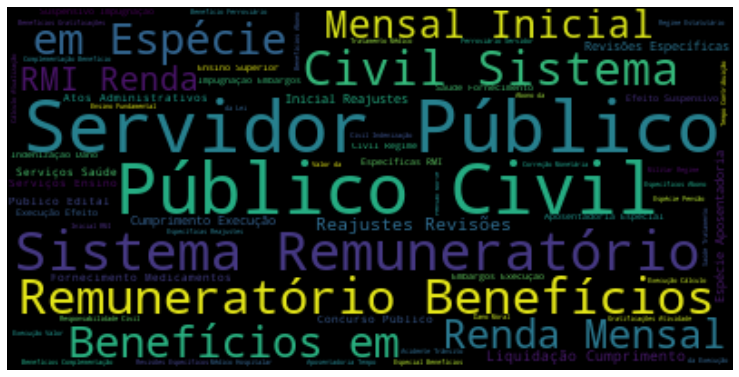

In [ ]:
#VERSÃO 1
areas = []
subareas = [] 

#Dividir os assuntos de cada processo, de modo a "descartar" a área geral do assunto
#e focar apenas nas subáreas, que são mais especificas
for value in new_data['assunto_y']:
  new_words = value.split('|') 
  areas.append(new_words[0])
  
  for word in new_words[1:]:
    subareas.append(word)

#Escolha de palavras que serão descartadas da análise
stopwords = set(STOPWORDS)
stopwords.update(["DIREITO", 'OUTRAS', 'MATÉRIAS', 'DE', 'POR', 'ART'])

texto = ', '.join(subareas)

#Apresentação da wordcloud
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(texto)
plt.figure(figsize=[13,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
   

###2ª versão - com agrupamento de palavras


Nessa segunda análise, foi visto que o termo mais específico para designar o assunto de um processo é o último (interpretado, no código, como sendo o penúltimo, pois o último espaço do vetor estava sendo preenchido com um espaço em branco). Dessa forma, foram realizadas duas mudanças: as palavras de cada termo foram unidas através de *underline* e o texto para o wordcloud foi formado apenas com os termos mais relevantes de cada assunto. 

Após as mudanças, é possível observar que - comparado ao gráfico anterior - esse apresenta menos repetição de palavras e uma análise mais correta, pois mantem as palavras de um mesmo termo conectadas entre si, diminuindo a distorção dos dados.

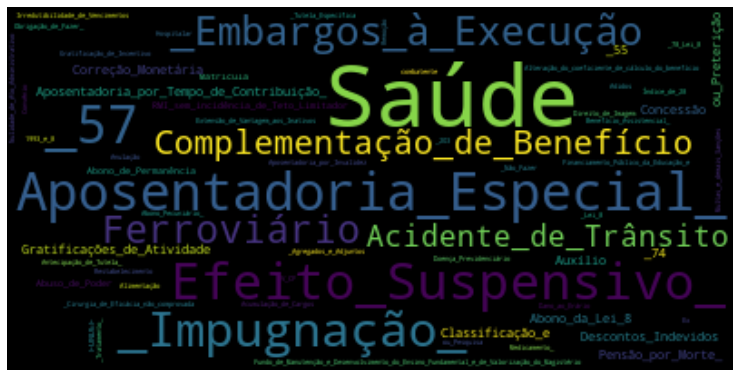

In [ ]:
area = []
subareas = [] 
termos = []

for value in new_data['assunto_y']:
  new_words = value.split('|')
  area.append(new_words[0].replace(" ", "_"))
  termos.append(new_words[-2].replace(" ", "_"))


#Escolha de palavras que serão descartadas da análise
stopwords = set(STOPWORDS)
stopwords.update(["DIREITO", 'OUTRAS', 'MATÉRIAS', 'DE', 'POR', 'ART'])

texto = ', '.join(termos)

wordcloud = WordCloud(stopwords=stopwords, background_color="black", collocations=False).generate(texto)
plt.figure(figsize=[13,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###3ª versão - com agrupamento de termos


Por fim, optou-se por agrupar - através de palavras chave - grupos de processos. Como a ideia da wordcloud não é ter um número específico de aparições de cada palavra e sim entender quais são as mais frequentes em um determinado texto, esse agrupamento serviria para ter uma noção de qual tipo de processo mais aparece. 

Para isso, utilizou-se a lista de palavras anteriormente definida: os últimos termos de cada assunto, isso é, o termo mais relevante de cada processo. 

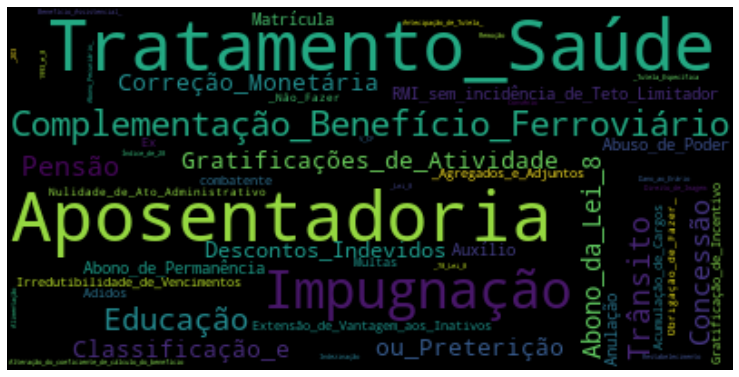

In [ ]:
#Agrupamento de subareas de assuntos de processos nomeando-os com o mesmo título, 
#de forma que na wordcloud os grupos predominantes sejam mais facilmente identificáveis

joinwords = ['Remuneratório|Remuneratórios', 'Aposentadoria', 'Médico|Saúde|Medicamento|Doença', 'Trânsito', 
             'Ensino|Educação', 'Indenização', 'Multa', 'Pensão', 'Renda', 'Impugnação', 'Ferroviário']

new_words = ['Benefício_Remuneratórios', 'Aposentadoria', 'Tratamento_Saúde', 'Trânsito', 
             'Educação', 'Indezinação', 'Multas', 'Pensão', 'Renda', 'Impugnação', 'Complementação_Benefício_Ferroviário']

palavras = pd.Series(termos)

for i in range(0, len(joinwords)):
  selection = palavras.str.contains(joinwords[i])
  palavras.loc[selection] = new_words[i]

#Wordcloud gerado com a lista de palavras modificadas
stopwords = set(STOPWORDS)
stopwords.update(["DIREITO", 'OUTRAS', 'MATÉRIAS', 'DE', 'POR', 'ART'])

texto2 = ','.join(palavras)

wordcloud = WordCloud(stopwords=stopwords, background_color="black", collocations=False).generate(texto2)
plt.figure(figsize=[13,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Distribuição de classes de processos 


###Utilizando dados das Seções Judiciárias


Nessa análise foi considerado o dataframe que apresenta a junção de todos os estados que compõem o TFR5, de modo a procurar quais classes de processos são mais frequentes. Para isso, foram escolhidas as que apresentam uma frequência maior do que 1%. Essas classes, juntas, correspondem a aproximadamente 91,4% das classes totais, de forma que a junção de todas as outras 113 (são 124, ao total, menos as 11 que foram selecionadas) corresponde a apenas cerca de 8,6%. Por esse motivo as classes que apresentam frequência maior que 1% foram priorizadas na aplicação do gráfico, e o restante foi agrupado com o título de "Outros".

In [ ]:
classes = df_jf['classe'].value_counts(normalize=True)*100

#Separação das classes que correspodem a mais de 1% das classes totais aparentes nos processoss
distribuicao_classes = {}
for name_class in classes.index:
  value_class = classes.loc[name_class]
  if(value_class > 1):
    distribuicao_classes[name_class] = value_class
     
#Atribuição da classe 'outros', com a porcentagem restante 
valor_total = sum(distribuicao_classes.values()) 
distribuicao_classes['OUTROS'] = 100-sum(distribuicao_classes.values())

#Apresentação do gráfico
labels = list(distribuicao_classes.keys())
values = list(distribuicao_classes.values())

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update(layout_title_text='Distribuição de classes de processo')
fig.show()

print("Quantidade total de classes existente no dataset:", len(classes))
print("Quantidade de classes que representa mais de 1% de frequência em relação a sua aparição no dataset: ", len(distribuicao_classes))

print("Porcentagem que as classes com mais de 1% de frequência representam em relação a todas as classes:", 
      valor_total, "%") 


Quantidade total de classes existente no dataset: 124
Quantidade de classes que representa mais de 1% de frequência em relação a sua aparição no dataset:  12
Porcentagem que as classes com mais de 1% de frequência representam em relação a todas as classes: 91.42328743158473 %


###Utilizando dados do Segundo Grau


A análise anterior foi feita utilizando-se do dataset das seções judiciárias (df_jf). No entanto, posteriormente esse dataset e o que apresenta os processos em segundo grau (df_proc) foram unidos através do número de processo. Ao fazer isso, a quantidade de classes e sua distribuição mudou, de forma que os dados apresentados serão diferentes. Para título de comparação foi usado exatamente o mesmo código da análise anterior, mudando apenas o dataset que está sendo analisado. 

A questão referente a selecionar, para apresentação no gráfico, apenas as classes que representam mais de 1% das classes totais se manteve. 

Vemos aqui quais as classes de processos mais frequentes ao observamos processos que foram para o segundo grau. 

In [ ]:
classes = new_data['classe'].value_counts(normalize=True)*100

#Separação das classes que correspodem a mais de 1% das classes totais aparentes nos processoss
distribuicao_classes = {}
for name_class in classes.index:
  value_class = classes.loc[name_class]
  if(value_class > 1):
    distribuicao_classes[name_class] = value_class
     
#Atribuição da classe 'outros', com a porcentagem restante 
valor_total = sum(distribuicao_classes.values()) 
distribuicao_classes['OUTROS'] = 100-sum(distribuicao_classes.values()) 

#Apresentação do gráfico
labels = list(distribuicao_classes.keys())
values = list(distribuicao_classes.values())

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update(layout_title_text='Distribuição de classes de processo')
fig.show()

print("Quantidade total de classes existente no dataset:", len(classes))
print("Quantidade de classes que representa mais de 1% de frequência em relação a sua aparição no dataset: ", len(distribuicao_classes))

print("Porcentagem que as classes com mais de 1% de frequência representam em relação a todas as classes:", 
      valor_total, "%") 

Quantidade total de classes existente no dataset: 69
Quantidade de classes que representa mais de 1% de frequência em relação a sua aparição no dataset:  8
Porcentagem que as classes com mais de 1% de frequência representam em relação a todas as classes: 94.41775044312043 %


##Distribuição do andamento dos processos 

Ao analisar os eventos que mais aparecem no dataset das seções judiciárias, observamos que 14 eventos, de todos os 278 rgistros que aparecerem no dataset, representam a grande maioria dos dados (foram "descartados" os que representam menos de 1% das entradas). 
Além disso, observa-se que existem palavras chave em cada um desses eventos. Dessa forma, foram criados títulos de forma a agrupar diferentes eventos que representem momentos de julgamento similar. Essa análise tinha como uma das intenções obter, de maneira clara a quantidade de processos que ainda estão em aberto e quantos já estão encerrados, conclusos ou suspensos. 

In [ ]:
#Os 14 eventos mais significativos
df_jf['ultimo_evento'].value_counts(normalize=True)[0:15]*100

Baixa Definitiva                                     34.179392
Juntada de Certidão de Intimação                     15.561443
Remetidos os Autos (em grau de recurso) para TRF5    12.320496
Juntada de Certidão                                   6.348437
Juntada de Petição                                    4.335591
Expedição de expediente                               2.982031
Juntada de Certidão de Retificação de Autuação        2.534676
Conclusos para decisão                                2.529678
Processo Suspenso/Sobrestado                          2.211781
Expedição de documento                                2.144303
Proferido despacho de mero expediente                 1.942369
Juntada de Cota                                       1.774423
Conclusos para julgamento                             1.550496
Juntada de Certidão de decurso de prazo               1.503511
                                                      0.920201
Name: ultimo_evento, dtype: float64

Esses eventos epresentam  95.28303301427037 % de todas as ultimas movimentações que ocorreram


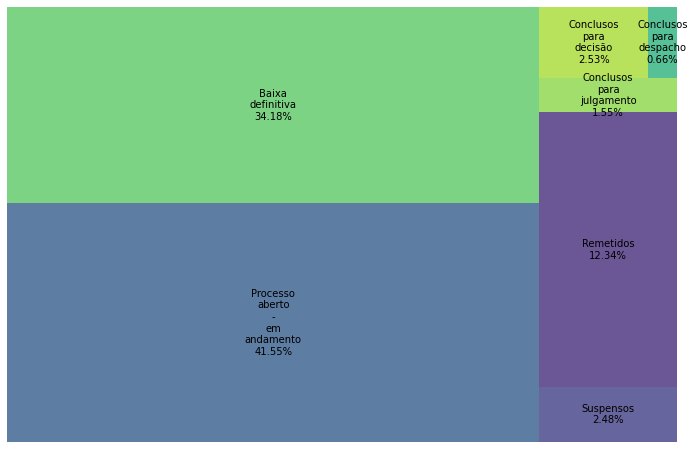

In [ ]:
eventos = df_jf['ultimo_evento'].value_counts(normalize=True, ascending = False)*100

#Palavras de busca  para poder agrupar os eventos 
searchwords = ['Expedição|Proferido|Juntada', 'Baixa', 'Suspenso', 'Remetido', 
               'Conclusos para julgamento', 'Conclusos para decisão', 'Conclusos para despacho']

#Titulos que serão usados como chaves do dicionário
titles = ['Processo aberto - em andamento', 'Baixa definitiva', 'Suspensos', 'Remetidos', 'Conclusos para julgamento', 
          'Conclusos para decisão', 'Conclusos para despacho']

ultimos_eventos = {}

for i in range(0, len(searchwords)):
  busca = (eventos.index).str.contains(searchwords[i])
  ultimos_eventos[titles[i]] = sum(eventos.loc[busca])

representacao = sum(ultimos_eventos.values())
print("Esses eventos epresentam ", representacao, "% de todas as ultimas movimentações que ocorreram")

#Contagem dos valores de 'ultimo_evento', em porcentagem e ordenados em ordem decrescente
andamento = new_data['ultimo_evento'].value_counts(normalize=True, ascending = False)*100
fig1, ax1 = plt.subplots(figsize=(12,8))

labels = []
for value in ultimos_eventos.keys():
  label_name = value
  label_value = ultimos_eventos[value]
  label_value_format = ('{:.2f}%'.format(label_value))
  label_text = label_name + "\n" + label_value_format
  
  labels.append(label_text.replace(' ', '\n'))


squarify.plot(sizes=ultimos_eventos.values(), label=labels, alpha=.8, text_kwargs={'fontsize':10})
plt.axis('off')
plt.show()

É possível observar que cerca de 42% dos processos ainda estão em tramitação ativa, juntamente com 12% que estão remetidos e 2.5% dos que estão suspensos - mas que ainda não foram conclusos ou tiveram baixa - de modo que cerca de 57% dos processos ainda precisa ser encerrado.  

##Distribuição dos processos entre as jurisdições do Rio Grande do Norte

Considerando as seis principais jurisdições do Rio Grande do Norte, foi observada a quantidade de processos em cada uma dessas jurisdições, considerando o primeiro dataset - o que apresenta os dados das seções judiciárias. 

In [ ]:
locais_varas = {}

#Separação das varas por jurisdição
varas_natal = ['1ª VARA FEDERAL', '2ª VARA FEDERAL', '3ª VARA FEDERAL',  '4ª VARA FEDERAL',
              '5ª VARA FEDERAL', '6ª VARA FEDERAL', '7ª VARA FEDERAL', '14ª VARA FEDERAL']
varas_mossoro = ['8ª VARA FEDERAL', '10ª VARA FEDERAL', '13ª VARA FEDERAL']
vara_caico = ['9ª VARA FEDERAL']
vara_assu = ['11ª VARA FEDERAL']
vara_pdf = ['12ª VARA FEDERAL']
vara_cm = ['15ª VARA FEDERAL']

varas = [varas_natal, varas_mossoro, vara_caico, vara_assu, vara_pdf, vara_cm]
titulos_varas = ['Natal', 'Mossoró', 'Caicó', 'Assu', 'Pau dos Ferros', 'Ceará-Mirim']

#Preenchendo a coluna local_vara com a cidade específica para cada vara
for i in range(0, len(varas)):
  df_rn.loc[df_rn['vara'].isin(varas[i]), "local_vara"] = titulos_varas[i]

processos_por_vara = df_rn['local_vara'].value_counts().sort_index()

#Dados sobre as cidades de cada jurisdição, retirado no site do TRF5 e agrupados em uma planilha excel
cidades_jurisdicoes = pd.read_excel('/content/drive/My Drive/Dados IC/jurisdicoes.xlsx')

jurisdicao_pdf = []
jurisdicao_mossoro = []
jurisdicao_assu = []
jurisdicao_caico = []
jurisdicao_cm = []
jurisdicao_natal = []

nomes_jurisdicoes = ['Assu', 'Caico', 'Ceara Mirim', 'Mossoro', 'Natal', 'Pau dos Ferros']
jurisdicoes = [jurisdicao_assu, jurisdicao_caico, jurisdicao_cm, 
               jurisdicao_mossoro, jurisdicao_natal, jurisdicao_pdf]

#Para cada uma das jurisdições agrupa os processos dessa jurisdição e guarda, em uma lista, 
#as cidades que a compõem 
for i in range(0, len(jurisdicoes)):
  selecao_cidades = cidades_jurisdicoes[cidades_jurisdicoes['jurisdicao'] == nomes_jurisdicoes[i]]
  for cidade in selecao_cidades['cidade']:
    jurisdicoes[i].append(cidade)

#Dados de população retirados do site do IBGE - planilha de projeção da população para o ano de 2018
ibge_rn = pd.read_excel('/content/drive/My Drive/Dados IC/ibgern2018.xlsx')

populacao_varas = {}
titulos_varas = ['Assu', 'Caicó', 'Ceará-Mirim', 'Mossoró', 'Natal', 'Pau dos Ferros']

#Calcula a quantidade de habitantes que existe em cada uma das jurisdições através
#da soma dos habitantes de cada uma das cidades que a compõem.
for i in range(0, len(titulos_varas)):
  df_jurisdicao = ibge_rn.loc[ibge_rn['NOME DO MUNICÍPIO'].isin(jurisdicoes[i])]
  populacao_varas[titulos_varas[i]] = sum(df_jurisdicao['POPULAÇÃO ESTIMADA'])


processos_por_vara = df_rn['local_vara'].value_counts().sort_index()
processos_por_habitante = []

for vara in populacao_varas.keys():
  value = populacao_varas[vara]
  processos_por_habitante.append(processos_por_vara[i]/value)

#Coordenadas das cidades "centro" da jurisdição  
latitudes_cidades = [-5.5788985, -6.4637139, -5.523514,  -5.1952329, -5.7999146, -6.1123308]
longitudes_cidades = [-36.9603518, -37.1219451, -35.479615, -37.4116808, -35.2922849, -38.2139801]

#Criação de um dataset com os dados encontrados
d = {'cidade': nomes_jurisdicoes, 'processos_varas': processos_por_vara,
     'processos_hab': processos_por_habitante, 
     'lat': latitudes_cidades, 'long':longitudes_cidades}
df_proc_hab = pd.DataFrame(data=d)  



In [ ]:
processos_por_vara

Assu               1260
Caicó              1965
Ceará-Mirim        1051
Mossoró            4782
Natal             27613
Pau dos Ferros     1021
Name: local_vara, dtype: int64

###Sem normalização


Mapa plotado contando apenas com a quantidade de processos em cada jurisdição, sem considerar a quantidade de habitantes em cada uma dessas regiões. É possível observar a grande predominância de processos na região de Natal.

In [ ]:
mapa_rn = folium.Map(location=[-5.79448, -35.211], zoom_start=7.5)

for i in range(0,len(df_proc_hab)):
  folium.Circle(
      location=[df_proc_hab.iloc[i]['lat'], df_proc_hab.iloc[i]['long']],
      popup=str(df_proc_hab.iloc[i]['cidade']),
      tooltip=str(df_proc_hab.iloc[i]['processos_varas']),
      radius=float(df_proc_hab.iloc[i]['processos_varas']),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(mapa_rn)

mapa_rn

###Com normalização


No entando, é incorreto avaliar o mapa da maneira como foi vista anteriormente, considerando a diferença populacional de cada uma dessas cidades. Um exemplo disso é o fato de Natal ser a cidade mais populosa do estado, de forma que é estatísticamente explicável essa maior predominância no número de processos.

No mapa a seguir, então, foi considerado o valor normalizado para cada uma dessas regiões, obtido através da divisão da quantidade de processos pela quantidade de habitantes. Após isso, é possível ver como a jurisdição de Natal passa a ter muito menos significância quando comparada as outras. Com os valores normalizados temos que as cidades com maior incidência de processos por habitantes são Pau dos Ferros, Assu e Ceará Mirim.

Os valores de "processos-por-habitantes" podem ser vistos pousando o mouse em cima de cada bolha.

In [ ]:
mapa_rn_normatizado = folium.Map(location=[-5.79448, -35.211], zoom_start=7.5)

for i in range(0,len(df_proc_hab)):
  folium.Circle(
      location=[df_proc_hab.iloc[i]['lat'], df_proc_hab.iloc[i]['long']],
      popup=str(df_proc_hab.iloc[i]['cidade']),
      tooltip=str(df_proc_hab.iloc[i]['processos_hab']),
      radius=float(df_proc_hab.iloc[i]['processos_hab']*10000000),
      #multiplicado por 10^7 apenas pra poder visualizar melhor as diferenças de tamanho
      color='green',
      fill=True,
      fill_color='green'
   ).add_to(mapa_rn_normatizado)

mapa_rn_normatizado

###Outro formato de exibição

In [ ]:
nomes_jurisdicoes = ['Assu', 'Caico', 'Ceara Mirim', 'Mossoro', 'Natal', 'Pau dos Ferros']
jurisdicoes = [jurisdicao_assu, jurisdicao_caico, jurisdicao_cm, 
               jurisdicao_mossoro, jurisdicao_natal, jurisdicao_pdf]
processos_habitante = df_proc_hab['processos_hab']

lista_cidades = []
lista_j = []
lista_processos = []

#Criando um novo df que contenha o nome das cidades 
for i in range(0, len(jurisdicoes)):
    for cidade in jurisdicoes[i]:
      lista_cidades.append(cidade)
      lista_j.append(nomes_jurisdicoes[i])
      lista_processos.append(processos_habitante[i])

d = {'cidade': lista_cidades, 
     'jurisdicao': lista_j,
     'proc_hab': lista_processos}

df_cidades_proc = pd.DataFrame(data=d)
#Correção de um nome
df_cidades_proc['cidade'].replace("Olho dÁgua dos Borges", "Olho-d'Água do Borges", inplace=True)


br_states = os.path.join('geojson', '/content/drive/My Drive/Dados IC/geojs-24-mun.json')
geo_json_data = json.load(open(br_states,encoding='latin-1'))

#Criação do mapa
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=7,
    tiles='Stamen Terrain')

#Criação de uma legenda
threshold_scale = np.linspace(df_cidades_proc['proc_hab'].min(),
                              df_cidades_proc['proc_hab'].max(), 6, dtype=int).tolist()

folium.Choropleth(
    geo_data=geo_json_data,
    data=df_cidades_proc,
    columns=['cidade', 'proc_hab'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    legend_name='Número de processos por habitante',
    highlight=True,
    line_color = '#00000000'
    #threshold_scale = threshold_scale
).add_to(m)

m


##Distribuição dos processos - em Segundo grau - entre todos os estados do TRF5

Análise da quantidade de processos que foram para recurso em cada um dos estados que compõem o TRF5. 
É possível perceber que o estado que apresenta maior quantidade de recursos é Pernambuco, sendo seguido pela Ceará e depois pelo Rio Grande do Norte. Esses estados apresentam, respectivamentem 0.0037, 0.0027 e 0.0024 processos por habitante.

In [ ]:
grau2_por_estado = pd.pivot_table(new_data, index='uf', values='num_processo', aggfunc='count')
grau2_por_estado.reset_index(inplace = True)

hab_estados = [3337357, 9132078, 4018127, 9557071, 3506853, 2298696]

i = 0
for uf in grau2_por_estado['uf']:
  selection = grau2_por_estado.loc[grau2_por_estado['uf'] == uf]
  valor_atual = selection['num_processo']
  grau2_por_estado.loc[grau2_por_estado['uf'] == uf, "quant_processos_normat"] = valor_atual/hab_estados[i]
  i +=1

grau2_por_estado.sort_values(by='quant_processos_normat', ascending=False)

br_states = os.path.join('geojson', '/content/drive/My Drive/Dados IC/brazil-states.geojson')
geo_json_estados = json.load(open(br_states,encoding='latin-1'))

#Criação do mapa
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=6,
    tiles='Stamen Terrain'
)

#Criação de uma legenda
threshold_scale = np.linspace(grau2_por_estado['quant_processos_normat'].min(),
                              grau2_por_estado['quant_processos_normat'].max(), 6, dtype=int).tolist()

folium.Choropleth(
    geo_data=geo_json_estados,
    data=grau2_por_estado,
    columns=['uf', 'quant_processos_normat'],
    key_on='feature.properties.sigla',
    fill_color='BuPu',
    legend_name='Número de processos do 2º grau por habitante',
    highlight=True,
    line_color = '#00000000'
    #threshold_scale = threshold_scale
  ).add_to(m)

m


##Quantidade de processos ao longo dos anos

####Utilizando data_distribuicao

Com base na data de distribuição do processo foram criadas duas novas colunas: mês e ano. Através dessas colunas é possível ver a distribuição da quantidade de processos ao longo dos meses e anos.

In [ ]:

#Separação dos anos, em ordem crescente
anos = (new_data['ano'].sort_values().unique())[-6:-1]
#Últimos 5 anos, contando a partir de 2018

selection = new_data.loc[new_data['ano'].isin(anos)]

proc_por_mes = selection.pivot_table(index=['ano','mes'], values='num_processo', aggfunc='count')
proc_por_mes.reset_index(inplace = True)

In [ ]:
fig = px.line(proc_por_mes, x="mes", y='num_processo', color='ano')

fig.update_layout(title='Quantidade de processos por mês, em cada ano',
                   xaxis_title='Mês',
                   yaxis_title='Número de processos',
                   xaxis = dict(
                       tickmode = 'array',
                       tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       ticktext = ['Janeiro','Fevereiro','Março','Abril','Maio',
                                   'Junho','Julho','Agosto','Setembro','Outubro',
                                   'Novembro','Dezembro']
                       )
                   )
fig.show()

####Utilizando primeira movimentação



In [ ]:
new_data['ano'] = pd.DatetimeIndex(new_data['data_distrib']).year
new_data['mes'] = pd.DatetimeIndex(new_data['data_distrib']).month

datas_mov = []

#Vê a data de movimentação
for movimentacao in df_mov['movimento']:
  data_d = movimentacao.split(" ")[0]
  datas_mov.append(data_d)

df_mov['data_mov'] = datas_mov
df_mov['data_mov'] = pd.to_datetime(df_mov['data_mov'])
primeiro_grau = df_mov.loc[df_mov['aplicacao'] == '1º Grau']

In [ ]:
#Ordena por número de processo e depois por data de movimentacao, o num_processo do maior pro menor
#e a data do menor pro maior
df_proc_sort = primeiro_grau.sort_values(['num_processo', 'data_mov'], ascending=[False, True])

#Pega a primeira linha de cada num_processo (a menor data)
df_distrib = df_proc_sort.groupby('num_processo').first().reset_index()

In [ ]:
df_distrib['ano'] = pd.DatetimeIndex(df_distrib['data_mov']).year
df_distrib['mes'] = pd.DatetimeIndex(df_distrib['data_mov']).month

#Separação dos anos, em ordem crescente
anos = (df_distrib['ano'].sort_values().unique())[-6:-1]
#Últimos 5 anos, contando a partir de 2018

selection = df_distrib.loc[df_distrib['ano'].isin(anos)]

proc_por_mes = selection.pivot_table(index=['ano','mes'], values='num_processo', aggfunc='count')
proc_por_mes.reset_index(inplace = True)

###Quantidade de processos por mês e por ano

In [ ]:
fig = px.line(proc_por_mes, x="mes", y='num_processo', color='ano')

fig.update_layout(title='Quantidade de processos por mês, em cada ano',
                   xaxis_title='Mês',
                   yaxis_title='Número de processos',
                   xaxis = dict(
                       tickmode = 'array',
                       tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       ticktext = ['Janeiro','Fevereiro','Março','Abril','Maio',
                                   'Junho','Julho','Agosto','Setembro','Outubro',
                                   'Novembro','Dezembro']
                       )
                   )
fig.show()

In [ ]:
proc_mai_dez = proc_por_mes[proc_por_mes['mes'].isin(range(5,13))]

fig = px.line(proc_mai_dez, x="mes", y='num_processo', color='ano')

fig.update_layout(title='Quantidade de processos por mês, em cada ano (Maio - Dez)',
                   xaxis_title='Mês',
                   yaxis_title='Número de processos',
                   xaxis = dict(
                       tickmode = 'array',
                       tickvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       ticktext = ['Fevereiro','Março','Abril','Maio',
                                   'Junho','Julho','Agosto','Setembro','Outubro',
                                   'Novembro','Dezembro']
                       )
                   )
fig.show()


###Quantidade total de processos ao longo dos anos


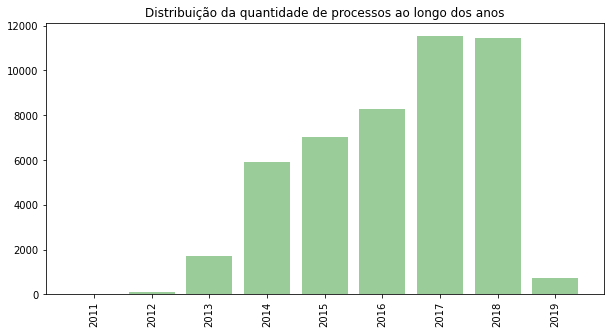

In [ ]:
# Agrupamento dos processos por ano
processos_por_ano = new_data['ano'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(processos_por_ano.index, processos_por_ano.values, alpha=0.4, color='green')

plt.xticks(processos_por_ano.index,rotation=90)
plt.title('Distribuição da quantidade de processos ao longo dos anos')

plt.show()

###Quedas e picos

In [ ]:
anos = proc_por_mes['ano'].unique()

quedas = []
picos = []

#Para cada ano nos ultimos 5 anos
for ano in anos:
  selection = proc_por_mes[proc_por_mes['ano'] == ano]
  
  #Seleciona o mês que teve o maior número de processos e guarda em uma lista: ano - mês - número de processos
  valor_pico = selection['num_processo'].max()
  mes_pico = selection[selection['num_processo'] == valor_pico]
  picos.append(', '.join(str(x) for x in mes_pico.values))

  
  #Seleciona o mês que teve o menor número de processos e guarda em uma lista: ano - mês - número de processos
  valor_queda = selection['num_processo'].min()
  mes_queda = selection[selection['num_processo'] == valor_queda]
  quedas.append(', '.join(str(x) for x in mes_queda.values))
  

print("Quedas: \n", quedas)
print("Picos: \n", picos)

Quedas: 
 ['[2013    8  145]', '[2014    8  127]', '[2015   10  130]', '[2016   10   64]', '[2017   10   55]']
Picos: 
 ['[2013    1 1453]', '[2014    1 2835]', '[2015    1 3484]', '[2016    1 3312]', '[2017    1 2583]']


É possível observar que, nos últimos 5 anos, os meses que apresentam uma **queda** no número de processos - isto é, que tiveram a menor quantidade de processos naquele ano - são os meses de Outubro (3 casos) e Agosto (2 casos). Sabendo do período de férias dos julgamentos, esse comportamento é justificável.

E ao analisar os pontos de **pico** vemos que todos ocorrem durante o mês de Janeiro, comportamento possívelmente explicado pelo recesso de fim de ano, onde os processos ficam retidos e entram em circulação apenas no mês seguinte. 

É possível, no entanto, verificar mais a fundo para entender os motivos para os valores de meses que se destacam. 

##Assuntos em alta durante cada mês que apresentou comportamento particular

No entanto, verificar o mês que apresenta o maior ou menor número de processos em cada ano não é o suficiente. Apenas com esse dado não é possível verificar se havia um crescente ou decrescente de números de processos ao longo de todo aquele período, de modo que o ponto de pico ou de queda não apresente nenhuma relação externa.

Pensando nisso, foi análisado quais eram os meses - para cada um dos últimos 5 anos - que apresentavam mudanças mais bruscas no quesito número de processos quando comparado com o mesmo número no mês anterior. Conjecturou-se que meses que apresentam mudanças mais bruscas foram afetados por causas externas, e não por um seguimento natural da quantidade de processos ao longo de um ano. 

Além disso, para cada um desses meses foram analisados quais assuntos estavam em alta, de modo a supor que esses assuntos interferiram nesse comportamento particular no quesito quantidade de processos. Para análisar se o assunto era relevante ou não, adotou-se uma proposta parecida com o que foi feito para o mês: verificou-se quais os assuntos em alta durante todo o ano e quantidade de vezes que cada um desses apareciam. Em seguida, realizou-se uma escolha determinada pela quantidade de vezes que o processo apareceu no mês em análise atual e no mês anterior, se a diferença na quantidade desses dois meses fosse maior que o desvio padrão desse assunto ao longo dos anos, significa que esse assunto apresenta relevância. 


###Código


In [ ]:
#Função que encontra a distância entre dois meses (o atual e o anterior)
#de modo a encontrar as mudanças mais drátiscas em relação a quantidade
#de processos
def desvios(processos_mes):
  desvios_pmes = {}
  
  for i in range(0, len(processos_mes)):
    if(i != 0):
      mes_atual = processos_mes['num_processo'].iloc[i]
      mes_anterior = processos_mes['num_processo'].iloc[i-1]
      
      desvio = ((mes_anterior - mes_atual) ** 2)**(1/2)
      
      desvios_pmes[processos_mes['mes'].iloc[i]] = desvio
  return desvios_pmes
   
#Calcula a média entre os desvios encontrados e separa apenas os que 
#estiverem acima de 2*média
#O *2 foi pra filtrar as mudanças ainda mais acentuadas
def desvios_significativos(dic_desvios):
    meses_significativos = []
    
    mean = sum(dic_desvios.values())/len(dic_desvios)
    
    values = list(dic_desvios.values())
    keys = list(dic_desvios.keys())
    
    for i in range (0, len(values)):
      if(values[i] > 2*mean):
        meses_significativos.append(keys[i])
    
    return meses_significativos


def desvio_padrao_assuntos(meses_ant):
  assuntos_meses_ant = meses_ant['assunto_y'].value_counts()[:5]
  
  termos = {}
  for assunto in assuntos_meses_ant.index:
      linha_assunto = assuntos_meses_ant[assuntos_meses_ant.index == assunto]
      
      assuntos = assunto.split('|')
      termo = assuntos[-2]
      
      termos[termo] = linha_assunto[-1]
      
  desvio_assunto = {}  
  
  for t in termos.keys():
    desvio_assunto[t] = termos[t]/2
  
  return desvio_assunto



def mean_absolute_deviation(array):
  mean = sum(array)/len(array)
  distances = []
  
  for value in array:
    distances.append(abs(value-mean))
  
  list_mean = sum(distances)/len(distances)
  return list_mean


def devp_assuntos_ano(df_ano):
  #vê os 10 assuntos mais frequentes naquele ano
  assuntos_ano = df_ano['assunto_y'].value_counts()[:10]
  
  #separa os 12 meses 
  meses = df_ano['mes'].unique()
  
  devp_assunto = {}
  
  #para cada assunto, separa o dataframe que contém apenas ele
  for assunto in assuntos_ano.index:
    sel_assunto = df_ano[df_ano['assunto_y'] == assunto]
    
    valores = [] 
    termos = assunto.split('|')
    termo = termos[-2]
    
    #seleciona o df que contém aquele mês
    for mes in meses:
      sel_mes = sel_assunto[sel_assunto['mes'] == mes]
      
      valor = sel_mes['assunto_y'].value_counts()
      valores.append(valor)
      
    valor = mean_absolute_deviation(valores)
    devp_assunto[termo] = valor[-1]

  return devp_assunto




In [ ]:
lista_anos = []
lista_meses = []
lista_assuntos = []
lista_valores = []


for i in range(0, len(anos)):    
  #Seleciona as quantidades de processos por mês daquele ano em específico
  selection = proc_por_mes[proc_por_mes['ano'] == anos[i]]
  
  #Calcula os desvios
  desvios_selection = desvios(selection)
  
  #Calcula os desvios significativos (meses em que houve mudanças mais bruscas)
  meses_selection = desvios_significativos(desvios_selection)
  
  #Seleciona os dados referentes ao ano que está sendo observado
  sel_ano = new_data[new_data['ano'] == anos[i]]
  
  #Vê os desvios padrãos para cada assunto daquele ano
  desviop_assuntos = devp_assuntos_ano(sel_ano)

  #Verifica, para cada mês, qual era o assunto que estava em alta para
  #tentar diagnosticar o motivo dessa mudança
  for mes in meses_selection:
    
    #Seleciona os dados do mês em especifico
    sel_mes_assunto = sel_ano[sel_ano['mes'] == mes]
    
    #Seleciona os dados do mes anterior ao que está sendo analisado
    sel_mes_ant = sel_ano[sel_ano['mes'] == mes-1]

    #Verifica quais são os assuntos mais frequentes daqueles meses (atual e anterior)
    top_assuntos_mes = sel_mes_assunto['assunto_y'].value_counts()[:10]
    assuntos_mes_ant = sel_mes_ant['assunto_y'].value_counts()
    
    termos_mes = []
    valores_assuntos = {}
   
    #para cada um dos assuntos em alta no mês
    for assunto in top_assuntos_mes.index:
      
      #vê quantas vezes aquele valor apareceu
      valor = top_assuntos_mes[top_assuntos_mes.index == assunto].values
      
      #separa o termo relevante
      assuntos = assunto.split('|')
      termo = assuntos[-2]
      
      #se o assunto está presente nos assuntos do mes anterior, então
      if(assunto in assuntos_mes_ant):
        
        #vê quantas vezes aquele assunto apareceu no mês anterior
        valor_ant = assuntos_mes_ant[assuntos_mes_ant.index == assunto].values
        
        #vê qual foi o desvio desse assunto em especifico 
        valores_assuntos[termo] = valor - valor_ant 
      else:
        valores_assuntos[termo] = valor
    
    #para cada termo do dicionario que criamos, vamos  
    for termo in valores_assuntos.keys():
      valor_atual = valores_assuntos[termo]

      #se o termo existe no dicionario dos desvios dos assuntos do ano
      if(termo in desviop_assuntos.keys()):
        
        #acha o valor no dicionario desse termo em especifico
        valor_devp_ano = desviop_assuntos[termo]

        #verifica se o valor de desvio atual é maior que a média do desvio padrão
        #desse assunto ao longo de todo o ano
        if(valor_atual > valor_devp_ano):
          
          linha_valor = top_assuntos_mes[top_assuntos_mes.index == assunto]
      
          lista_anos.append(anos[i])
          lista_meses.append(mes)
      
          lista_assuntos.append(termo)
          termos_mes.append(termo)
      
          lista_valores.append(linha_valor[-1])
      else:
        
          linha_valor = top_assuntos_mes[top_assuntos_mes.index == assunto]
      
          lista_anos.append(anos[i])
          lista_meses.append(mes)
      
          lista_assuntos.append(termo)
          termos_mes.append(termo)
      
          lista_valores.append(linha_valor[-1])
     

In [ ]:
dd = {'ano': lista_anos, 'mes': lista_meses,
     'assunto': lista_assuntos, 
     'quant_aparicoes': lista_valores}

df_assuntos_meses = pd.DataFrame(data=dd)
df_grouped = df_assuntos_meses.groupby(['ano', 'mes', 'assunto']).sum()
df_grouped.reset_index(inplace=True)

###Visualização


Foi apresentado um gráfico para cada um dos últimos cinco anos (2014 - 2018).

Os meses são representados pelos pontos laranjas, e os demais pontos representam os assuntos relevantes naquele mês. É possível notar que alguns assuntos estão relacionados com mais de um mês. As cores dos pontos que representam os assuntos variam de acordo com a quantidade de vezes que esse mesmo assunto apareceu.

In [ ]:
for year in anos:
  df = df_grouped[df_grouped['ano'] == year]
  

  # Cada assunto e réu será tratado como um nó no gráfico
  node1 = list(df['mes'].unique())
  node2 = list(df['assunto'].unique())
  node_list = list(set(node1+node2))

  # Criação de um gráfico networkx
  G = nx.Graph()

  # Inserindo os nós no gráfico
  for i in node_list:
      G.add_node(i)

  # Criando as conexões entre os nós
  for i,j in df.iterrows():
      G.add_edges_from([(j['mes'],j["assunto"])])

  # Posições dos nós no gráfico
  pos = nx.kamada_kawai_layout(G)
  for n, p in pos.items():
      G.nodes[n]['pos'] = p

  edge_trace = go.Scatter(
      x=[],
      y=[],
      line=dict(width=0.8,color='#888'),
      hoverinfo='none',
      mode='lines')

  for edge in G.edges():
      x0, y0 = G.nodes[edge[0]]['pos']
      x1, y1 = G.nodes[edge[1]]['pos']
      edge_trace['x'] += tuple([x0, x1, None])
      edge_trace['y'] += tuple([y0, y1, None])

  #Escala lateral
  node_trace = go.Scatter(
      x=[],
      y=[],
      text=[],
      mode='markers',
      hoverinfo='text',
      marker=dict(
          showscale=True,
          colorscale = 'speed',
          #px.colors.sequential.Viridis,
          reversescale=True,
          color=[],
          size=17,
          colorbar=dict(
              thickness=17,
              title='Grau de Conectividade do Nó',
              xanchor='left',
              titleside='right'
          ),
          line=dict(width=0)))

  for node in G.nodes():
      x, y = G.nodes[node]['pos']
      node_trace['x'] += tuple([x])
      node_trace['y'] += tuple([y])


  meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio','Junho', 'Julho', 
           'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

  for node, adjacencies in enumerate(G.adjacency()):
    if adjacencies[0] in range(0,13):
      node_trace['marker']['color'] += tuple(['rgb(200,55,0)'])
      aux = adjacencies[0]
      node_info = meses[aux-1]
      node_trace['text']+=tuple([node_info])
    else:
      node_trace['marker']['color']+=tuple([len(adjacencies[1])])
      node_info = adjacencies[0]
      node_trace['text']+=tuple([node_info])    

  # Gráfico
  

  texto = "<br>Assuntos em alta durante meses que apresentaram comportamento particular em relação a quantidade de processos - "
  ano = str(year)
  texto_completo = texto + ano
  
  fig = go.Figure(data=[edge_trace, node_trace],
               layout=go.Layout(
                  title = texto_completo,
                  titlefont=dict(size=14),
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=20,l=5,r=5,t=40),
                  annotations=[ dict(
                      showarrow=False,
                      text='',
                      xref="paper", yref="paper") ],
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

  fig.show()


##Número de Réus e de Advogados

Foi observado que não existe um padrão quando se trata na quantidade de réus ou advogados em um processo. Assim, foi feita uma análise para identificar quais são as quantidades mais comuns, de modo a poder, se preciso, analisar os casos que fogem da curva. 


In [ ]:
num_reus = []
num_adv = []

for processo in df_proc['polo_passivo']:
  reus = processo.split("\n")
  
  advogados = reus.count("ADVOGADO")
  inicial_adv = advogados

  apelados = reus.count("APELADO")
  inicial_reus = apelados
  
  num_reus.append(inicial_reus)
  num_adv.append(inicial_adv)

df_proc["num_reus"] = num_reus
df_proc["num_adv"] = num_adv

###Réus

Foi considerado 4 réus como valor de "quebra", isto é, todo processo que apresentasse mais de 4 réus será considerado como caso específico, e todos esses foram agrupados sob a legenda "+4". Além disso, vamos que existe uma quantidade de processos que não apresenta nenhum réu, caso que precisa também ser estudado mais a fundo. Ademais, como era o esperado, a quantidade mais comum é a de 1 ou 2 réus por processo.

In [ ]:
#Apresentação do gráfico
list_quant_reus = []
list_reus = df_proc['num_reus'].value_counts()
values = []

for quant_reu in list_reus.index:
  value = list_reus[quant_reu]
  porcent = value/sum(list_reus.values)
  if(porcent > 0.01):
    list_quant_reus.append(quant_reu) 
    values.append(value)

list_quant_reus.append('+4')
values.append(sum(list_reus.values)-sum(values))

fig = go.Figure(data=[go.Pie(labels=list_quant_reus, values=values)])
fig.update(layout_title_text='Número de Réus')
fig.show()

####Assuntos mais frequentes nos processos com mais de quatro réus

Verificar se o tipo do assunto nesses processos com número atípico de réus apresenta/representa algo relevante, que possa estar relacionado ao comportamento.

In [ ]:
df_quatro = df_proc[df_proc['num_reus'] >= 4]

lista_assuntos = []
for assunto in df_quatro['assunto']:
  assuntos = assunto.split("|")
  lista_assuntos.append(assuntos[-2])

df_quatro["assunto_relevante"] = lista_assuntos


In [ ]:
assuntos_quatro = pd.DataFrame(df_quatro["assunto_relevante"].value_counts()[:20]).reset_index()
assuntos_quatro = assuntos_quatro.rename(columns={'assunto_relevante': 'quant_aparicoes', 'index': 'assunto'})

fig = px.bar(assuntos_quatro, x='assunto', y='quant_aparicoes',
            hover_data=['quant_aparicoes'], color='quant_aparicoes',
              height=400)

fig.show()


####Assuntos mais frequentes em processos que não contém réus

In [ ]:
df_zero = df_proc[df_proc['num_reus'] == 0]

lista_assuntos = []
for assunto in df_zero['assunto']:
  assuntos = assunto.split("|")
  lista_assuntos.append(assuntos[-2])

df_zero["assunto_relevante"] = lista_assuntos

In [ ]:
assuntos_zero = pd.DataFrame(df_zero["assunto_relevante"].value_counts()[:20]).reset_index()
assuntos_zero = assuntos_zero.rename(columns={'assunto_relevante': 'quant_aparicoes', 'index': 'assunto'})

fig = px.bar(assuntos_zero, x='assunto', y='quant_aparicoes',
            hover_data=['quant_aparicoes'], color='quant_aparicoes',
            height=400)

fig.show()

####Tipo de Polo passivo em casos que não há réu

In [ ]:
reus = []
advogados = []

for processo in df_zero['polo_passivo']:
  polos_passivos = processo.split("\n")
  tamanho = len(polos_passivos)

  for i in range(0, tamanho):
    if(polos_passivos[i] == 'ADVOGADO'):
      advogados.append(polos_passivos[i])
      advogados.append(polos_passivos[i-1])

    elif(i < tamanho-1 and polos_passivos[i+1] == 'ADVOGADO'):   
      continue

    else:
      reus.append(polos_passivos[i])

  sr_reus = pd.Series(reus)
  

In [ ]:
count_reus = sr_reus.value_counts()
d = {'nome': count_reus.index, 'quantidade': count_reus.values}
df_reus = pd.DataFrame(data=d)

termos_reus = df_reus[~(df_reus['nome'].str.contains(' '))]
parte_re = df_reus[df_reus['nome'] == "PARTE RÉ"]

termos_reus = pd.concat([termos_reus, parte_re])


In [ ]:
fig = px.bar(termos_reus, x='nome', y='quantidade',
            hover_data=['quantidade'], color='quantidade',
            height=400)

fig.show()

###Advogados

In [ ]:
list_quant_adv = []
list_adv = df_proc['num_adv'].value_counts()
values = []

for quant_adv in list_adv.index:
  value = list_adv[quant_adv]
  porcent = value/sum(list_adv.values)
  if(porcent > 0.01):
    list_quant_adv.append(quant_adv) 
    values.append(value)

list_quant_adv.append('+4')
values.append(sum(list_adv.values)-sum(values))

fig = go.Figure(data=[go.Pie(labels=list_quant_adv, values=values)])
fig.update(layout_title_text='Número de Advogados')
fig.show()

##Tempo entre a distribuição e a decisão

In [ ]:
datas_mov = []

#Vê a data de movimentação
for movimentacao in df_mov['movimento']:
  data_d = movimentacao.split(" ")[0]
  datas_mov.append(data_d)

df_mov['data_mov'] = datas_mov
df_mov['data_mov'] = pd.to_datetime(df_mov['data_mov'])

In [ ]:
#Ordena por número de processo e depois por data de movimentacao, o num_processo do maior pro menor
#e a data do menor pro maior
df_proc_sort = df_mov.sort_values(['num_processo', 'data_mov'], ascending=[False, True])

#Pega a primeira linha de cada num_processo (a menor data)
df_distrib = df_proc_sort.groupby('num_processo').first().reset_index()

df_proc_s = df_mov.sort_values(['num_processo', 'data_mov'], ascending=[False, False])
df_dec = df_proc_s.groupby('num_processo').first().reset_index()



df_decisao = df_dec[df_dec['movimento'].str.lower().str.contains('decisão')]
new_df_distrib = pd.DataFrame()

for processo in df_decisao['num_processo']:
  new_df_distrib = new_df_distrib.append(df_distrib[df_distrib['num_processo'] == processo])

df_decisao = df_decisao.sort_values('num_processo')
new_df_distrib = new_df_distrib.sort_values('num_processo') 

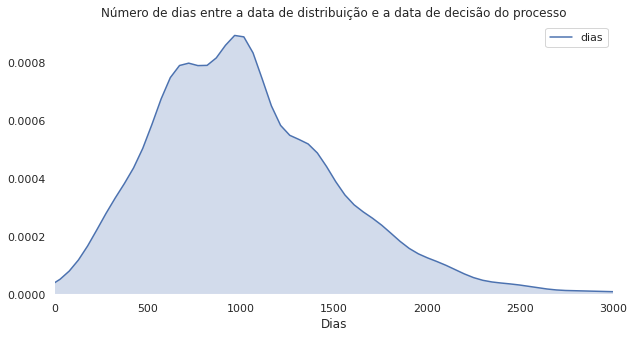

In [ ]:
julgamento = pd.DataFrame()
julgamento['dias'] = [(i-j).days for i,j in zip(df_decisao['data_mov'], new_df_distrib['data_mov'])]

# Gráfico com a distribuição dos dias entre a data de distribuição e a data de sentença

sns.set(rc={'figure.figsize':(10,5)})
sns.set_context("notebook")
sns.set_style("white")
sns.kdeplot(julgamento['dias'], shade=True)
plt.xlabel("Dias")
plt.xlim(0,3000)
sns.despine(bottom=True, left=True)
plt.title('Número de dias entre a data de distribuição e a data de decisão do processo')
plt.show()

#Outras possíveis análises




*   Quais as classes processuais relacionadas a processos com polo passivo diferente do réu
*   Verificar a existência de advogados de outros estados em mais de 5 processos do estado observado (entre todos os do TRF5)
*   Relacionar os assuntos com os réus (nodegraph)
*   Observar quais são os processos com final 0000
*   Refazer distribuição do andamento dos processos utilizando o Streamlit, de modo a poder aprofundar esse intervalo de dados
*   Verificar a quantidade de recursos por região (*checar relevância*)
*   Quantidade de processos por cada "tipo de direito" (assuntos[0])
*   Observar mudanças no polo passivo ao mudar de 1º para 2º Grau










